# Auto Cluster
### Loading ICU Data

In [11]:
import pandas as pd
import numpy as np
import os
import app

def get_data():
	try:
		return pd.read_csv(app.DATA_PATH)
	except:
		return pd.read_csv(os.getcwd() + "/data/icu_data_with_na_v2.csv")

### Sillhoutte Analysis
Aiming to estimate the number of clusters that we should cluster to without user input, as data is first examined (no feature transformations?)

/var/folders/y6/pght29y10p56pqbrywqnnfs40000gn/T/ipykernel_43237/3654906824.py:8: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cols = [data.columns[col] for col in range(len(data.columns)) if data.dtypes[col] != np.object]


For n_clusters = 2 The average silhouette_score is : 0.4052749366556749
For n_clusters = 3 The average silhouette_score is : 0.20632611631268538
For n_clusters = 4 The average silhouette_score is : 0.19831328370672838
For n_clusters = 5 The average silhouette_score is : 0.2174174138298926
For n_clusters = 6 The average silhouette_score is : 0.221410921023848
For n_clusters = 7 The average silhouette_score is : 0.1618631441613117
For n_clusters = 8 The average silhouette_score is : 0.15852852192711983
For n_clusters = 9 The average silhouette_score is : 0.16190108866725306


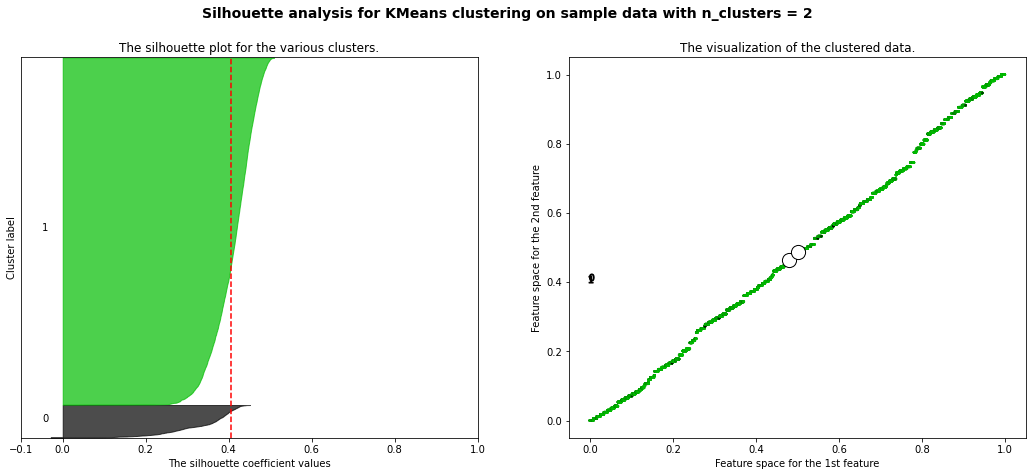

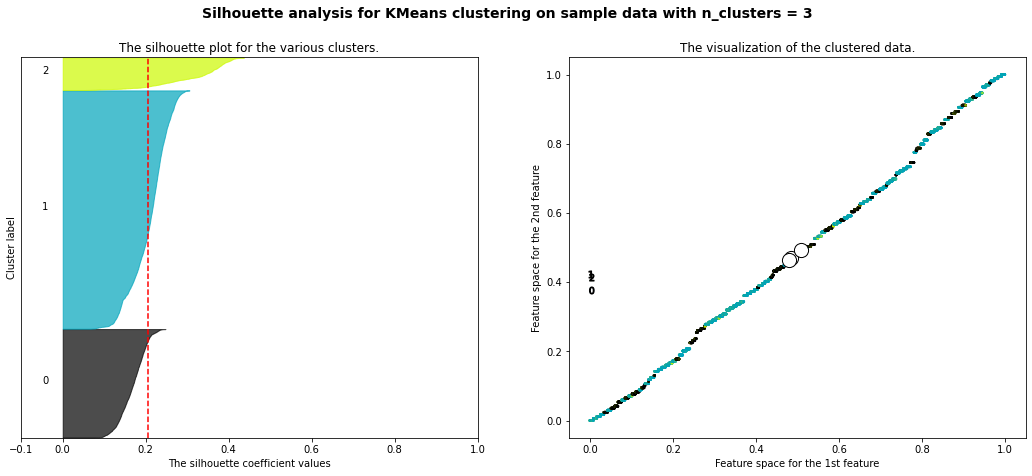

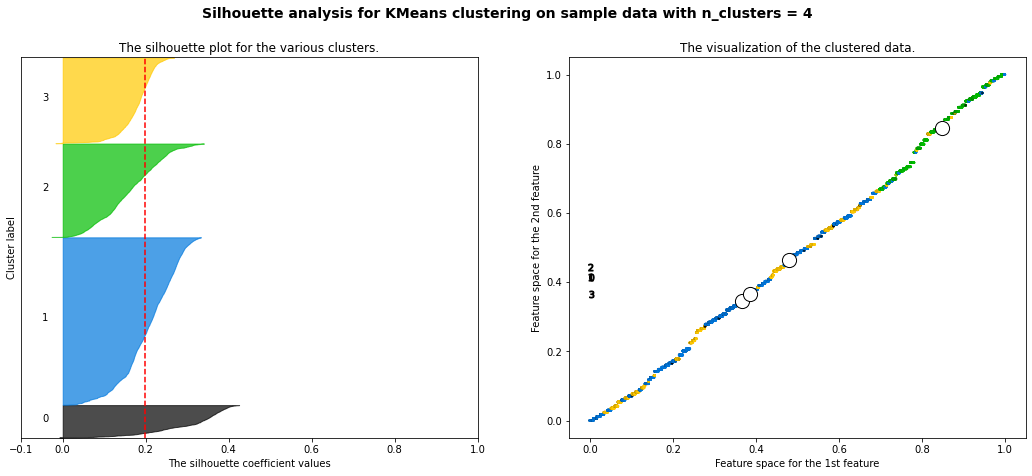

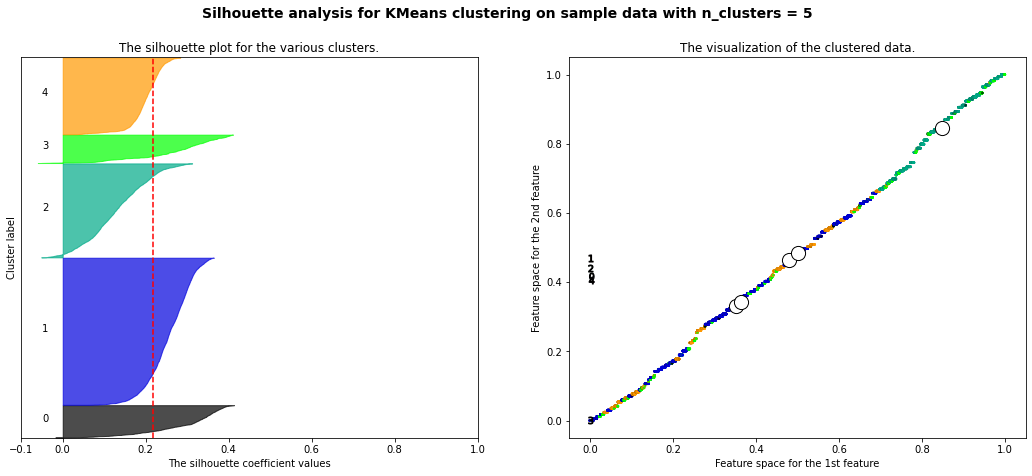

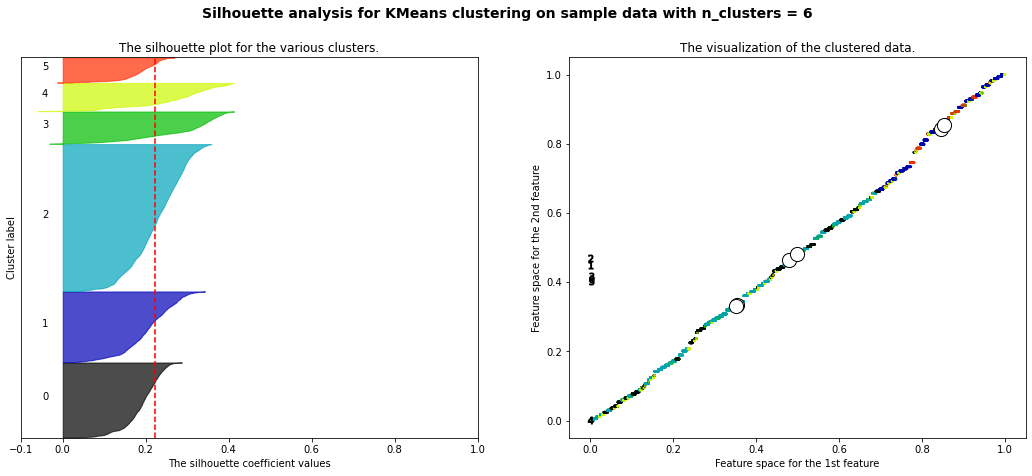

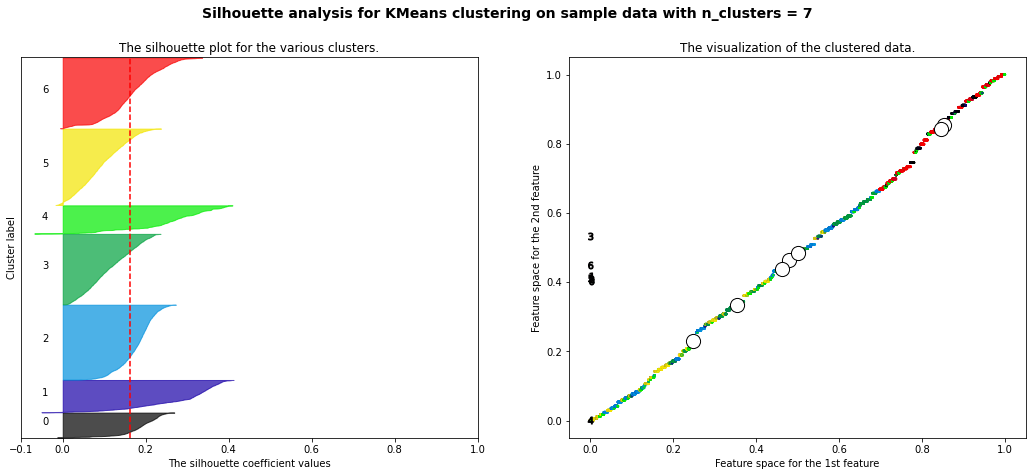

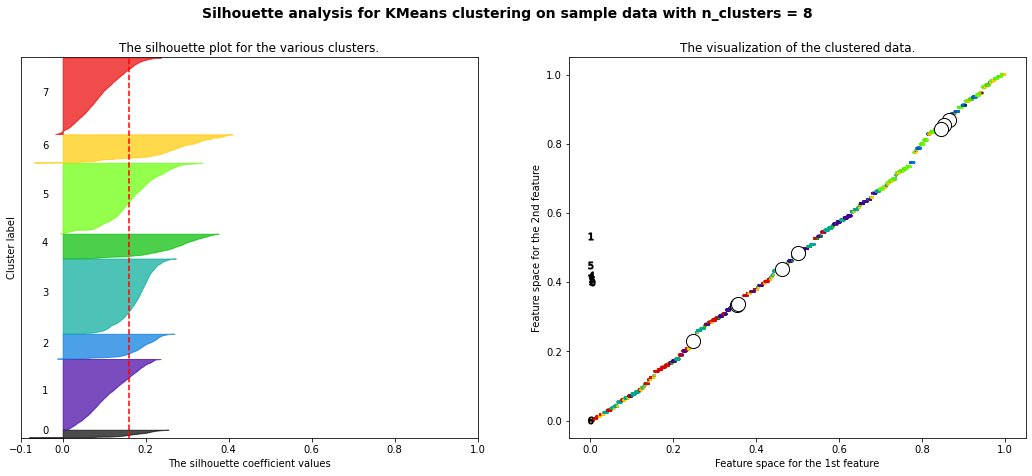

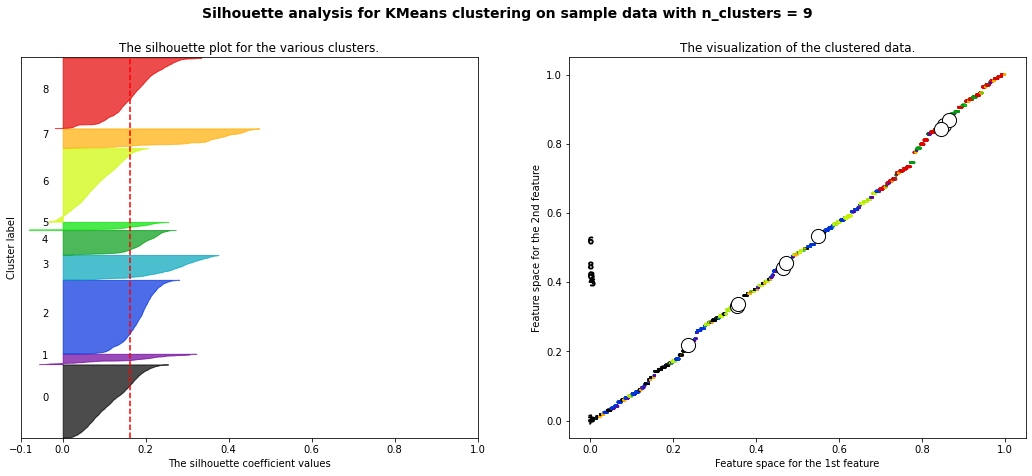

In [6]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm

data = get_data()

cols = [data.columns[col] for col in range(len(data.columns)) if data.dtypes[col] != np.object]

X = data[cols].fillna(0).copy()
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

for n_clusters in range(2,10):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
    model = KMeans(
        n_clusters=n_clusters, init="k-means++",
        n_init=10,
        tol=1e-04, random_state=42
    )
    cluster_labels = model.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = model.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [ ]:
# TODO: Implement automatic selection from Sillhouette Analysis

### Feature Transformations
Applying feature transformations such that the data can be prepared in a way for the end users liking prior to grouping

In [53]:
import warnings
warnings.filterwarnings('ignore')

def transform(data, feature_transform_method = 1):
    # Method 1 :: replace NaNs with 0 and not NaNs with 1
    if feature_transform_method == 1:
        for col in data.columns:
            data[col].loc[~data[col].isna()] = 1
        return data.fillna(0)
    # Method 2 :: take average values available per patient
    elif feature_transform_method == 2:
        smaller_data = pd.DataFrame(columns=data.columns)

        for i in data["id"].unique():
            new_row = []
            # Taking a smaller dataframe wherein only the current patient is used
            sub_df = data.loc[data["id"] == i+1]
            curr_len = len(sub_df)
            
            # New list is appended by the availability of data
            new_list = 1 - sub_df.isna().sum() / curr_len
            print(new_list)

            smaller_data.loc[len(smaller_data)] = new_list
        
        return smaller_data
    # Method 3 :: 
    elif feature_transform_method == 3:
        # TODO : new feature transform methods
        raise NotImplementedError()
    else:
        raise ValueError("Feature transform method not present")
        

### Grouping the Data
Utilising KMeans clustering, we can group the data that has been tranformed

In [54]:
def cluster(n_clusters = 4):
    data = transform(get_data(), feature_transform_method = 1)
    
    model = KMeans(
        n_clusters=n_clusters, random_state=42
    )
    return model.fit_predict(data)

In [55]:
cluster(3)

array([1, 0, 1, ..., 2, 2, 2], dtype=int32)

### Project Clusters into 2D
Using UMAP, we can project the clusters into 2D plots

In [ ]:
# TODO: UMAP plotting of clusters